# Классификация обложек альбомов метал-групп по поджанрам. Описание проекта.

Ссылка на Kaggle: https://www.kaggle.com/datasets/fraserwtt/metal-album-art-by-subgenre

В этом проекте будет проведена бинарная классификация поджанров метал-музыки на основе изображений обложек альбомов. Рассматриваться будут альбомы музыкальных групп, играющих блэк и пауэр метал. Я только начинаю свой путь в области компьютерного зрения, поэтому для осуществления поставленно цели будет использоваться библиотека fast.ai, основанная на библиотеке PyTorch. Она представляет собой простой в использовании высокоуровневый интерфейс для быстрого прототипирования и обучения моделей глубокого обучения.

Оценивать качество моделей будем по значению метрики F1.

# Загрузка данных.

Подключаем облачный диск, на котором лежат обложки альбомов.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загружаем необходимые далее библиотеки.

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import F1Score

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as plt
import requests
import io
from IPython.display import display

Фиксируем переменные, которые вскоре понадобятся моделям.

In [3]:
PATH = Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Metal covers')
SEED = 42

Выведем по 5 обложек каждого поджанра с подписями.

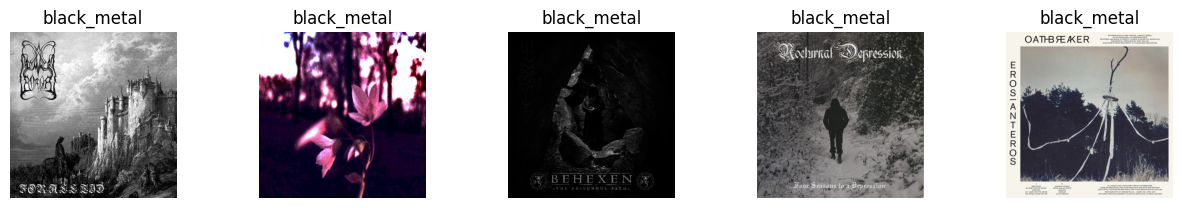

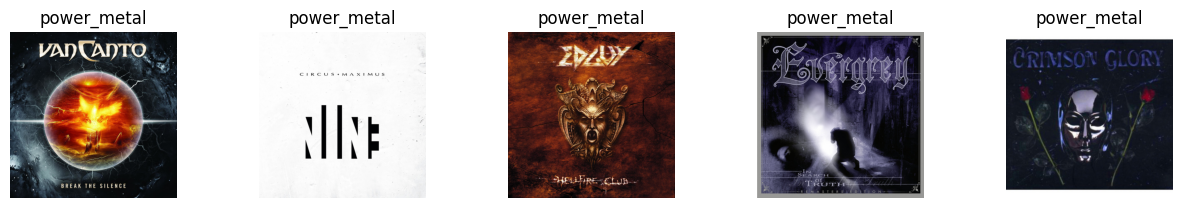

In [7]:
# Путь к папке с обложками альбомов в жанре блэк метал.
black_metal_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Metal covers/black_metal'

# Путь к папке с обложками альбомов в жанре пауэр метал.
power_metal_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Metal covers/power_metal'

def show_random_images_with_labels(image_folder, label):
    image_files = os.listdir(image_folder)
    random_files = random.sample(image_files, 5)  # Выбор 5 случайных изображений
    fig = plt.figure(figsize=(15, 3))
    for i in range(5):
        img = Image.open(os.path.join(image_folder, random_files[i]))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

show_random_images_with_labels(black_metal_path, 'black_metal')
show_random_images_with_labels(power_metal_path, 'power_metal')

По этой маленькой выборке можно предположить, что на обложках альбомов групп, играющих пауэр метал, больше ярких цветов да и в целом палитра обширнее, чем у блэкарей.

# Обучение моделей, выбор наилучшей из них, проверка на внешних данных.

Оценим возможности нескольких предварительно обученных моделей. Будут выполнены вычисления их значений метрики F1 на валидационной выборке, результаты сохранены в словарь для последующего анализа, а также построена матриц ошибок для каждой модели.

Модель <function resnet18 at 0x7f9b2b694940>


epoch,train_loss,valid_loss,f1_score,time
0,0.971807,0.659974,0.774468,00:39


epoch,train_loss,valid_loss,f1_score,time
0,0.610363,0.628293,0.800821,00:39
1,0.483223,0.499653,0.815315,00:39
2,0.359169,0.532030,0.849785,00:39
3,0.254542,0.467420,0.841871,00:38
4,0.187613,0.482272,0.841410,00:39


Величина метрики F1 равна: 0.8414096916299559



Модель <function resnet34 at 0x7f9b2b694af0>


epoch,train_loss,valid_loss,f1_score,time
0,0.914778,0.624243,0.747153,00:42


epoch,train_loss,valid_loss,f1_score,time
0,0.535119,0.671488,0.811475,00:41
1,0.430783,0.406434,0.835267,00:42
2,0.312246,0.394474,0.859688,00:42
3,0.202745,0.384125,0.860262,00:39
4,0.143912,0.377167,0.864629,00:42


Величина метрики F1 равна: 0.8646288209606986



Модель <function resnet50 at 0x7f9b2b694ca0>


epoch,train_loss,valid_loss,f1_score,time
0,0.826689,0.641409,0.793926,00:45


epoch,train_loss,valid_loss,f1_score,time
0,0.497769,0.481455,0.827423,00:49
1,0.372653,0.457787,0.836782,00:49
2,0.269960,0.502860,0.839560,00:49
3,0.182653,0.447094,0.834081,00:49
4,0.124648,0.449200,0.838137,00:49


Величина метрики F1 равна: 0.8381374722838139



[0.8414096916299559, 0.8646288209606986, 0.8381374722838139]

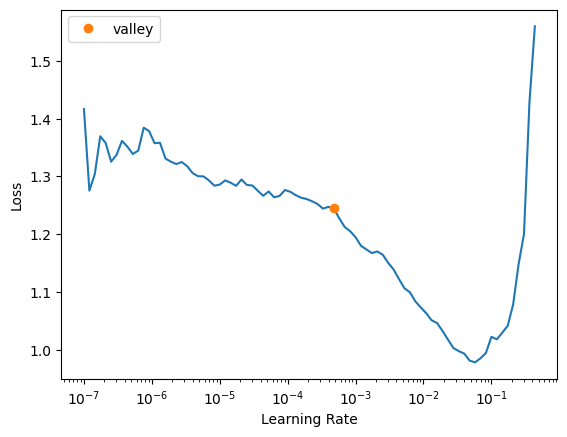

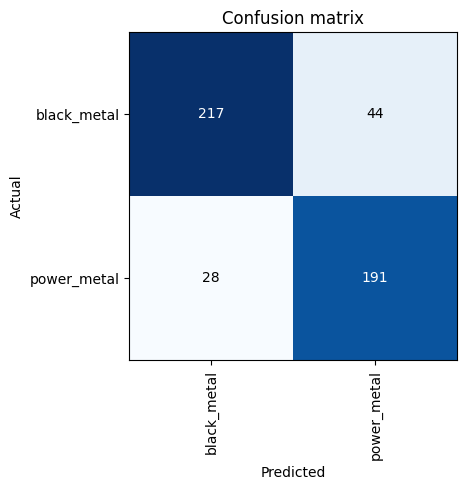

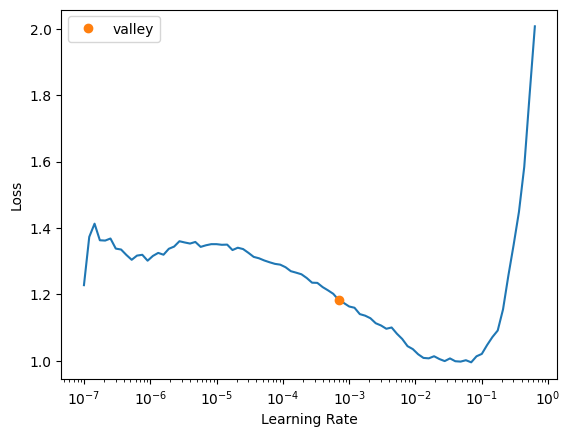

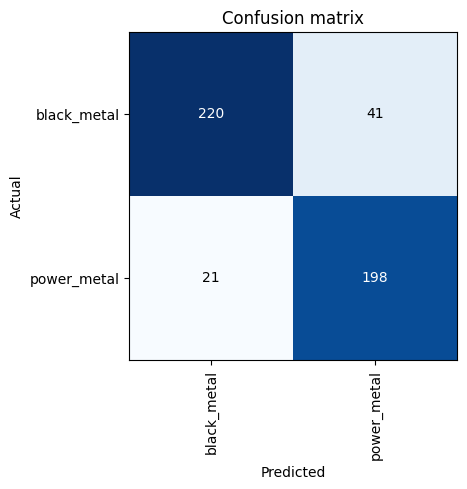

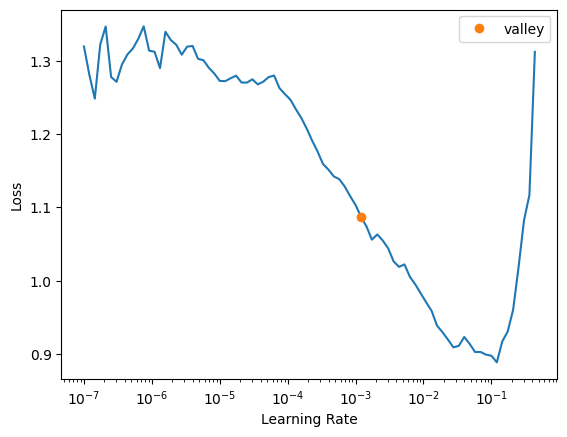

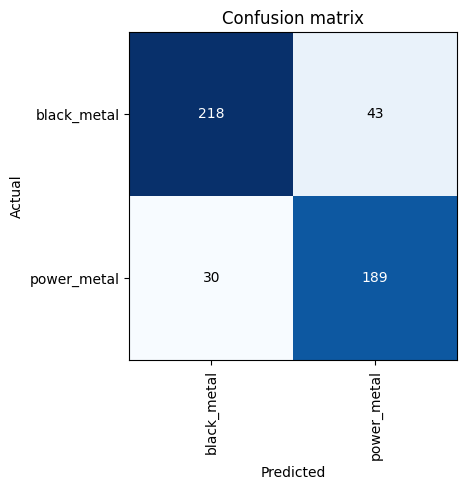

In [10]:
# Создаём список моделей, которые будут использоваться и пустой список, куда будут попадать их значения метрики
pretrained_models = [resnet18, resnet34, resnet50]
f1_scores = []

for model in pretrained_models:
    print(f"Модель {model}")
    # Загрузка данных и автоматическое разделение на тренировочную и валидационную выборки,
    # изменение размера изображений до 300х300 пикселей, применение к ним аугментации и нормализации,
    # выбор размера батча, выбор F1 в качестве метрики
    dls = ImageDataLoaders.from_folder(
        PATH,
        valid_pct=0.2,
        seed=SEED,
        item_tfms=Resize(300),
        batch_tfms=[*aug_transforms(size=300), Normalize.from_stats(*imagenet_stats)],
        bs=64,
        metrics=F1Score(),
    )

    learn = vision_learner(dls, model, metrics=F1Score(), pretrained=True)

    # Нахождение оптимального learning rate
    learn.lr_find()

    # Обучение модели с оптимальным learning rate
    learn.fine_tune(5, base_lr=3e-3)

    # Получение значения метрики F1
    f1_score = learn.validate(dl=dls.valid)[1]
    print(f"Величина метрики F1 равна: {f1_score}")
    print("")
    f1_scores.append(f1_score)

    # Сохранение модели в файл с соответствующим именем
    learn.export(f"{model.__name__}_model.pkl")

    # Построение матрицы ошибок
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

f1_scores

По данным списка значений метрик строим столбчатую диаграмму.

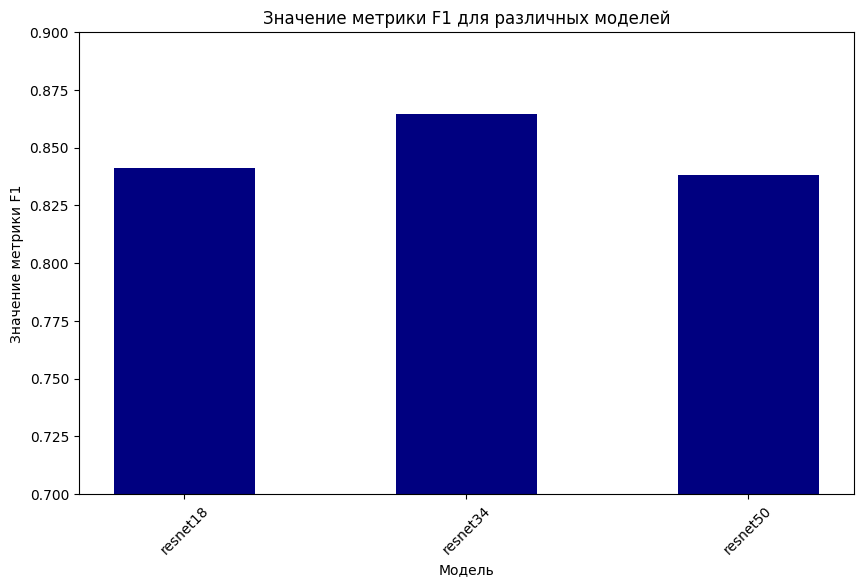

In [11]:
models = ['resnet18', 'resnet34', 'resnet50']

plt.figure(figsize=(10, 6)
plt.bar(models, f1_scores, color='navy', width=0.5)
plt.title('Значение метрики F1 для различных моделей')
plt.xlabel('Модель')
plt.ylabel('Значение метрики F1')
plt.xticks(rotation=45)
plt.ylim(0.7, 0.9)

plt.show()

Видим, что наилучшие результаты на этих данных показала модель ResNet34, значение метрики которой 0.86. Она верно определила 83% альбомов блэк метала и 90% пауэр метала.

Посмотрим, как она классифицирует по поджанрам метала обложки альбомов, которых вообще не было среди рассматриваемых данных. Я специально взял по 5 представителей каждого поджанра, которые вряд ли известны автору датасета, и загрузил их напрямую по ссылкам. Оценим результат.

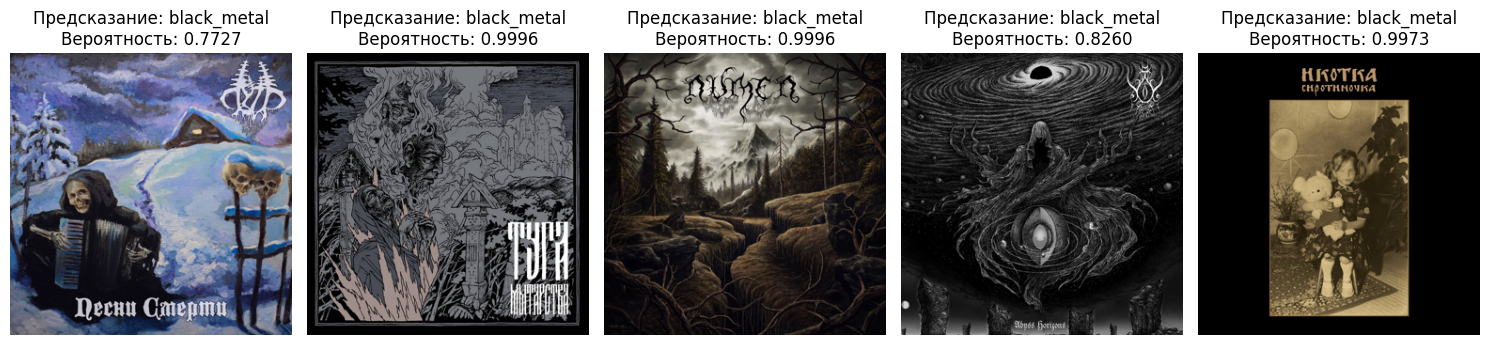

In [12]:
bm_image_urls = [
    'https://knife.media/wp-content/uploads/2020/08/Blek-metal-5-1024x1024.jpg',
    'https://knife.media/wp-content/uploads/2020/08/Blek-metal-3.jpg',
    'https://noizr.com/files/page/15/5e36fd62d8d761.jpg',
    'https://www.moshpitnation.com/wp-content/uploads/2020/07/a1532110824_16-700x675.jpg',
    'https://www.darkside.ru/band/22607/n62912.jpg',
]

learn = load_learner(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Metal covers/resnet34_model.pkl'
)

images = [Image.open(io.BytesIO(requests.get(url).content)) for url in bm_image_urls]

fig, axes = plt.subplots(1, len(bm_image_urls), figsize=(15, 5))

for i, (img, url) in enumerate(zip(images, bm_image_urls)):
    img = img.resize((300, 300))

    img = PILImage.create(np.array(img))

    pred, pred_idx, probs = learn.predict(img)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f'Предсказание: {pred}\nВероятность: {probs[pred_idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

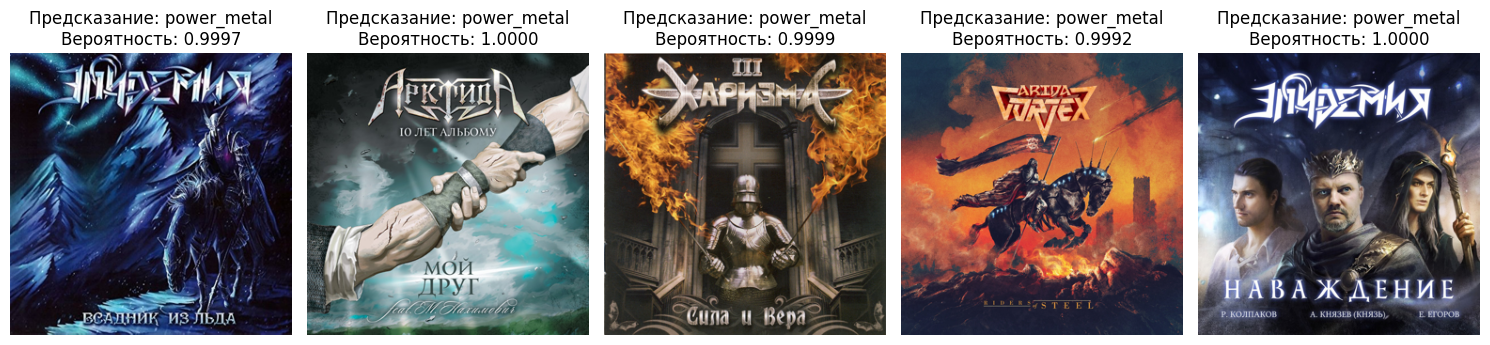

In [13]:
pm_image_urls = [
    'https://m.media-amazon.com/images/I/61SA9aQ3ZXL._UF1000,1000_QL80_.jpg',
    'https://i1.sndcdn.com/artworks-442a19e1-30b7-4467-8060-f09126224ec5-0-t500x500.jpg',
    'https://timba1987.narod.ru/kh/kharizma-discography/sila-i-vera.files/image006.jpg',
    'https://ir.ozone.ru/s3/multimedia-x/c1000/6037062717.jpg',
    'https://www.darkside.ru/band/530/n64173.jpg',
]

learn = load_learner(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Metal covers/resnet34_model.pkl'
)

images = [Image.open(io.BytesIO(requests.get(url).content)) for url in pm_image_urls]

fig, axes = plt.subplots(1, len(pm_image_urls), figsize=(15, 5))

for i, (img, url) in enumerate(zip(images, pm_image_urls)):
    img = img.resize((300, 300))

    img = PILImage.create(np.array(img))

    pred, pred_idx, probs = learn.predict(img)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f'Предсказание: {pred}\nВероятность: {probs[pred_idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()


Видим, что оба поджанра определены верно и с высокой точностью. Выбивается по точности только первая "чёрнометаллическая" обложка, возможно, из-за нехарактерных для поджанра цветов.

# Выводы.
Возможностей библиотеки fast.ai полностью хватило для рассматриваемых задачи и данных. Модель ResNet34, лучше всего показавшая себя при работе с нашим датасетом (величина метрики 0.86, верно распознано 220 из 261 блэк метал обложек и 198 из 219 пауэр метал обложек) , также точно классифицирует и изображения, скачанные из внешнего источника.